## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [3]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
import moments
import seaborn

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})

In [4]:
N = 2500
s = -10/N # 25/N -> gamma = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 2000 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [5]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [6]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [5]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*mu # singleton input

J = calcJK13(n)

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

In [913]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [914]:
# fs.integrate([1], 0.01*T, gamma=s*2*N, theta=0, h=0.5)
fs = fs.project([n]) * 2

Text(0, 0.5, 'iterate')

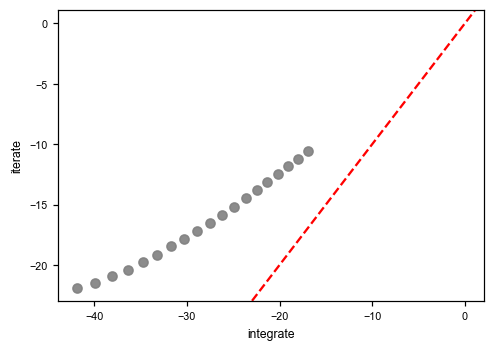

In [916]:
plt.scatter(np.log(np.abs(fs)), np.log(np.abs(mom[0,:])), color='grey', alpha=0.9)
plt.axline((0,0),slope=1,color='red',ls='--'); plt.xlabel('integrate'); plt.ylabel('iterate')

In [918]:
# for dt in 
fsmat = np.zeros((tot_gen,n+1))
for idt, dt in enumerate(np.linspace(1e-3*T,T,tot_gen)[::-1]):
    fs = moments.Spectrum(np.zeros(n + 1))
    fs[1] = n*1
    fs.integrate([1], dt, gamma=0.5*s*2*N, h=0.5, theta=0, adapt_dt=False)
    fsmat[idt,:] = mu*fs

KeyboardInterrupt: 

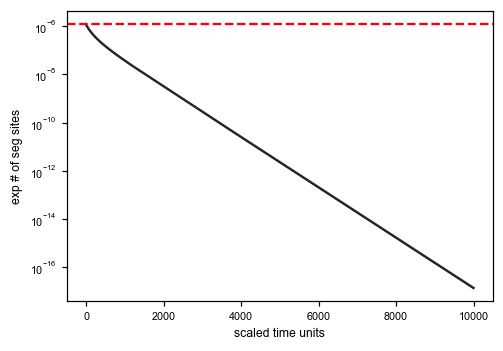

In [ ]:
plt.plot(range(10000)[::-1],np.sum(fsmat[:,1:100],axis=1),color='black',alpha=1)
plt.plot(range(10000)[::-1],np.sum(mom2[1:,1:100],axis=1),color='grey',alpha=0.3)
plt.semilogy(); plt.xlabel('scaled time units'); plt.ylabel('exp # of seg sites')
plt.axhline(n*mu, color='red', ls='--',label='sample scaled mutation rate')

Text(0, 0.5, 'scaled time units')

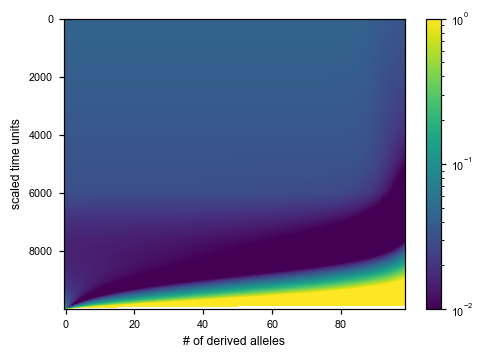

In [ ]:
# np.sum(fsmat[:,1:],axis=1)
plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])/mom2[:-2,1:100],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-2))
# plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100]),norm=colors.LogNorm(vmin=1e-20))
plt.colorbar(); plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units')

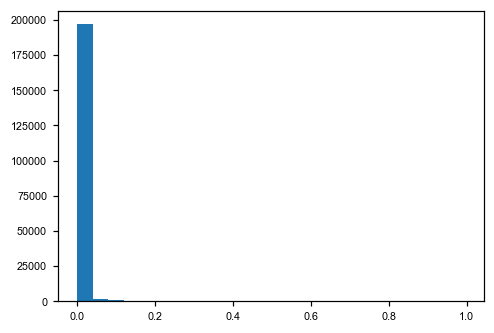

In [1036]:
# np.where(np.max(np.abs(fsmat[:,1:100]-mom2[time_steps,1:100])))
# mom2[time_steps,2]
plt.hist(np.ravel(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])),25);

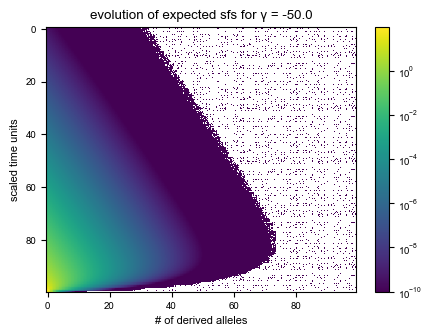

In [ ]:
plt.figure(dpi=100)
plt.imshow((fsmat[-100:,1:]),aspect='auto',norm=colors.LogNorm(vmin=1e-10))
plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

In [69]:
## testbed for a single realization of gen = t & the Crank-Nicolson method
mom[100,1] = n*1 # singleton input

dt = 1

D = 0.25/N * calcD(n+1)
J = calcJK13(n+1)
S = 0.5 * s * calcS(n+1, J)

# if N is same across all gens then only have to do this once
slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - dt / 2.0 * (D + S))
Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + dt / 2.0 * (D + S)

# going from generation 9 to 0
for gen in np.arange(100)[::-1]:

    # momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    momkp1[gen,iter] = mom[gen+1,iter] + slv(Q.dot(mom[gen+1,iter]))
    momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

IndexError: index 101 is out of bounds for axis 1 with size 101

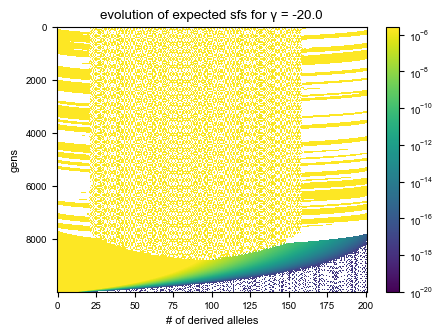

In [2316]:
# plt.figure(dpi=100)
# plt.imshow((mom2[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmin=1e-20))
# plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
# plt.colorbar(); plt.show()

plt.figure(dpi=100)
plt.imshow((mom[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmax=n*mu,vmin=1e-20))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

# plt.figure(dpi=90)
# plt.scatter(np.arange(tot_gen+1)[::-1][-100000:],(np.sum(mom[-100000:,:],axis=1)),alpha=0.7,color='k')
# plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')
# plt.axhline(n*1, color='red', ls='--',label='sample scaled mutation rate')
# plt.axvline(0.5*N, color='grey',label='N/2'); plt.legend()
# plt.axvline(tot_gen-np.max(np.where(np.sum(mom,axis=1)<0)), color='coral', ls='-.')

In [1043]:
# plt.hist(np.ravel(mom[8000:10000,30:]))
plt.scatter(np.arange(1,n+1),mom[-20000,1:],color='grey',label='iterate')
# plt.plot(np.arange(1,n+1),fs[1:],color='black',label='integrate')
plt.xlabel('# of derived alleles'); plt.ylabel('# of copies')
# plt.scatter(np.ravel(mom),np.ravel(mom2),alpha=0.5,color='grey'); plt.axline((0,0),(1,1),color='red')

IndexError: index -20000 is out of bounds for axis 0 with size 10001

In [8]:
def calcD(d):
    # res = np.zeros([d, d])
    # # loop over the fs elements:
    # for i in range(d):
    #     if i > 1:
    #         res[i, i - 1] = (i-1) * (d-i)
    #     if i < d - 2:
    #         res[i, i + 1] = (i+1) * (d-i-2)
    #     if i > 0 and i < d - 1:
    #         res[i, i] = -2 * i * (d-i-1)
    # return res
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            data.append((i-1) * (d-i))
            row.append(i)
            col.append(i - 1)
        if i < d - 2:
            data.append((i+1) * (d-i-2))
            col.append(i + 1)
            row.append(i)
        if i > 0 and i < d - 1:
            data.append(-2 * i * (d-i-1))
            row.append(i)
            col.append(i)

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [7]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [9]:
## packaging into a function for easy manipulation - iteration implementation 
# input: a (number of gens), n (number of samples), s, N (pop size)
# output: mom (number of sites)
def run_mom_iterate(a, n, s, N, mu, misc):
    mom = np.zeros((a+1,n+1))
    # momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    dt = 1

    D = 0.25/N * calcD(n+1)
    J = calcJK13(n)
    S = 0.5 * s * calcS(n+1, J)

    # if N is same across all gens then only have to do this once
    slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - dt / 2.0 * (D + S))
    Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + dt / 2.0 * (D + S)

    iter = np.arange(1,n)
    iterm1p1 = np.arange(2,n-1)

    mom[a,1] = 1 # singleton input

    # going from generation 9 to 0
    for gen in np.arange(a)[::-1]:
        # momkp1[iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

        # momkp1[1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
        # momkp1[n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

        # # notice the difference in indexing for LHS
        # momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

        # momkp1[iter] += 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])
        
        # momkp1[1:n] = mom[gen+1,1:n] + ((D[1:n,1:n] + S[1:n,1:n]) @ mom[gen+1,1:n])

        momkp1 = slv(Q.dot(mom[gen+1,]))
        momkp1[0] = momkp1[n] = 0.0

        mom[gen,] = deepcopy(momkp1)

    return n*mu*mom[:-1,:]           

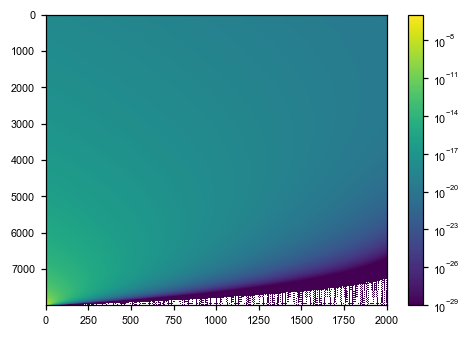

In [23]:
# fs = run_mom_integrate(4000, 1000, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs2 = run_mom_integrate2(4000, 200, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs2[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
mom = run_mom_iterate(8000, 2000, 0.5*gamma[10]/N, N, mu, np.nan)
plt.imshow(mom[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs.shape, mom.shape
# plt.scatter(np.ravel(mom[:,1:-1]), np.ravel(fs[:,1:-1]), color='grey', alpha=0.75, s=5); plt.loglog()
# plt.axline((0,0),(1,1),color='red',ls='--', linewidth=0.6); plt.xlabel('iterative framework'); plt.ylabel('integrative framework'); plt.title('γ = {}'.format(-100.))

In [59]:
# plt.scatter(np.ravel(fs), np.ravel(fs2), color='grey', alpha=0.75, s=5) #plt.loglog()
# plt.axline((0,0),slope=1,color='red',ls='--', linewidth=0.6); plt.xlabel('iterative framework'); plt.ylabel('integrative framework')
run_mom_integrate2(10000, 1000, 0.5*gamma[10]/2500, 2500, mu, misc = {'dt_fac':0.05, 'adapt_dt':True})

array([[1.24975278e-05, 5.35824948e-12, 5.34332025e-12, ...,
        5.05233728e-13, 5.04265657e-13, 5.50983593e-10],
       [1.24975272e-05, 5.36001455e-12, 5.34508005e-12, ...,
        5.05358895e-13, 5.04390538e-13, 5.50933428e-10],
       [1.24975267e-05, 5.36178027e-12, 5.34684051e-12, ...,
        5.05484084e-13, 5.04515441e-13, 5.50883250e-10],
       ...,
       [2.89333779e-06, 7.39210826e-06, 1.70441664e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.08980631e-06, 8.67696706e-06, 1.44488861e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.14000221e-06, 1.03283190e-05, 9.38071930e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [67]:
run_mom_integrate(50000, 1000, 0.5*gamma[24]/2500, 2500, mu, misc = {'dt_fac':0.05, 'adapt_dt':True})

array([[ 1.07438690e-05,  3.86219844e-06, -1.74625407e-06, ...,
         3.25593631e-15,  3.25597939e-15,  1.23737901e-08],
       [ 1.07439114e-05,  3.86212854e-06, -1.74624656e-06, ...,
         3.25659476e-15,  3.25663784e-15,  1.23737898e-08],
       [ 1.07439539e-05,  3.86205850e-06, -1.74623903e-06, ...,
         3.25725334e-15,  3.25729642e-15,  1.23737895e-08],
       ...,
       [ 2.88254329e-06,  7.39898276e-06,  1.70736087e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.08167602e-06,  8.68297927e-06,  1.44664738e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.13535970e-06,  1.03323142e-05,  9.38662129e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [35]:
## test-bed with sample numbers 
# a = 100000 # (total gens)
# fs = moments.Spectrum(np.zeros(31))
# fs[1] = 1
# print(fs)
# fs.integrate([1], dt, gamma=-10, h=0.5, theta=0)
# print(fs)

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [9]:
## function where each generation was integrated to separately
def run_mom_integrate(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    for idt, dt in enumerate(np.linspace(0.5/N,0.5*a/N,a)[::-1]):
        fs = moments.Spectrum(np.zeros(n + 1))
        fs[1] = 1
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = n*mu*fs
    return fsmat

## function where each generation is only integrated from previous generation
def run_mom_integrate2(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    dt = 0.5/N
    fs = moments.Spectrum(fsmat[-1,:])
    fs[1] = 1
    fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0)
    fsmat[-1,:] = fs
    for idt in np.arange(0,a-1)[::-1]:
        # fs = moments.Spectrum(fsmat[idt+1,:])
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = fs
    return n*mu*fsmat

In [48]:
## creating a database of P(X, a | s) with dicts for different s values
up_xa_s = {}
# gamma = -np.logspace(2,-2,25)
## use different lengths of time for each gamma (high gamma - small limits)
## go up to 5 orders of magnitude below start (i.e., E[# seg sites] < 1e-11)
limal = np.concatenate((np.linspace(6000,120000,15,dtype=int),np.repeat(150000,10)))
for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate(limal[ig], 2000, 0.5*g/2500, 2500, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # can project down to any sample size using moments.Spectrum(p_xa_s[g][-1,:]).project([20])*120/20

In [19]:
## took 19 hours for first 13 gamma values - estimate: approx 3 days for all gamma values (since smaller ones take longer)
## using fs.integrate...
## iterate only takes 2 mins
with open('testdata/fsintegrate.pkl', 'wb') as f:
    pkl.dump(up_xa_s, f)

In [2]:
## loading it back
import pickle as pkl
with open('testdata/fsintegrate.pkl', 'rb') as f:
    up_xa_s = pkl.load(f)

EOFError: Ran out of input

In [12]:
import sys
# check size of different data objects
# up_xa_s = {}
# for ig, g in enumerate(gamma):
#     up_xa_s[g] = np.random.randn(n*limal[ig]).reshape((n,limal[ig]))
sys.getsizeof(up_xa_s)

1176

ValueError: x and y must be the same size

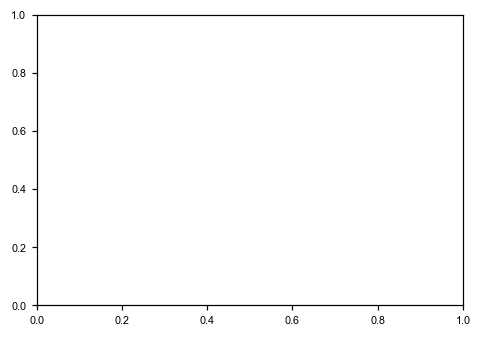

In [14]:
# use these plots to figure out when to stop (for gamma<1, ok could stop at 10k for high gamma)
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-1.],axis=1)),alpha=0.7,color='k')
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-.1],axis=1)),alpha=0.7,color='grey')
plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')

In [49]:
## scaling the matrix from above to get pdf (all rows sum to 1)
cutoff = 20 # 2 x # of inds
for g in gamma:
    # normalizing by rows (summing across gens)
    # p_xa_s[g] = up_xa_s[g]/up_xa_s[g].sum(axis=0,keepdims=1)
    # normalizing by rows and cols (summing across gens and # of derived alleles)
    # p_xa_s[g] = up_xa_s[g]/np.sum(up_xa_s[g])
    # normalizing by rows and cols and number of derived alleles (based on if detectable in sample or not)
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    up_xa_s[g][:,np.arange(cutoff)] = np.inf
    up_xa_s[g][:,np.arange(n-cutoff+1,n+1)] = np.inf

# import pickle as pkl
# with open('testdata/fsintegrate.pkl', 'wb') as f:
#     pkl.dump(up_xa_s, f)

In [70]:
np.log(np.min(up_xa_s[-10.][-1,:]))

-415.7400921526474

In [ ]:
## projecting the moments to a smaller sample size & then scaling (optional)
# ss = 20 # small sample
# pp_xa_s = {}
# for g in gamma:
#     pp_xa_s[g] = np.zeros((up_xa_s[g].shape[0],ss))
#     for i in range(up_xa_s[g].shape[0]):
#         pp_xa_s[g][i,:] = moments.Spectrum(up_xa_s[g][i,:]).project([ss]) * 150/ss
#     pp_xa_s[g] = pp_xa_s[g]/pp_xa_s[g].sum(axis=0,keepdims=1)

NameError: name 'p_xa_s' is not defined

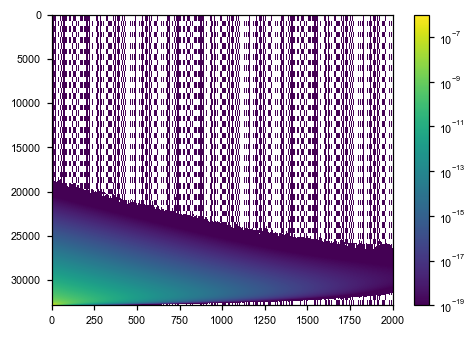

In [38]:
plt.imshow(up_xa_s[gamma[4]],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-20)); plt.colorbar()
# np.min(p_xa_s[gamma[4]][10,:])

### Reading in simulation data for comparison

In [10]:
import pandas as pd
df1 = pd.read_csv("traindata/trip-2022-02-15.csv")
df1['empty'] = ''
df1['sXl'] = np.ceil(df1['Xl']*n).astype(int)
gamma = np.unique(df1['gamma'])
dat = df1.to_numpy()
## drawing ages for alleles that died out instantly from a Poisson distribution

In [19]:
# df1['sXl'] = np.around(df1['Xl']*n).astype(int)
df1

,Xl,gamma,al,exp.al,empty,sXl
0,0.010700,-100.00,453.0,489.0883,,22
1,0.011150,-100.00,463.0,499.3779,,23
2,0.012000,-100.00,246.0,518.0679,,24
3,0.019150,-100.00,328.0,647.0010,,39
4,0.018275,-100.00,732.0,633.3336,,37
...,...,...,...,...,...,...
24995,0.012600,-0.01,274.0,2231.6540,,26
24996,0.013600,-0.01,929.0,2369.1720,,28
24997,0.020225,-0.01,3791.0,3219.9140,,41
24998,0.069600,-0.01,10977.0,7973.3340,,140


In [21]:
## function to obtain the log P(X,|gamma)
def get_lp_xl(g, sXlred, n=2000, cutoff=20):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    # lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    ub = np.exp(2.*g)*sp.special.expi(-2.*g*0.5*cutoff/n) - sp.special.expi(2.*g*(1-0.5*cutoff/n)) - np.exp(2.*g)*(np.log(0.5*cutoff/n) - np.log(1-0.5*cutoff/n))
    lb = np.exp(2.*g)*sp.special.expi(2.*g*(0.5*cutoff/n-1)) - sp.special.expi(2.*g*0.5*cutoff/n) - np.exp(2.*g)*(np.log(1-0.25/n) - np.log(0.5*cutoff/n))
    scalfact = (ub - lb)/np.expm1(2.*g)

    # return a vector...
    for isx, sx in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[isx] = (1-np.exp(-2*g*(1-sXlred[sx]/n)))/(sXlred[sx]/n*(1-sXlred[sx]/n)*(1-np.exp(-2*g)))

    return np.log(res/scalfact)

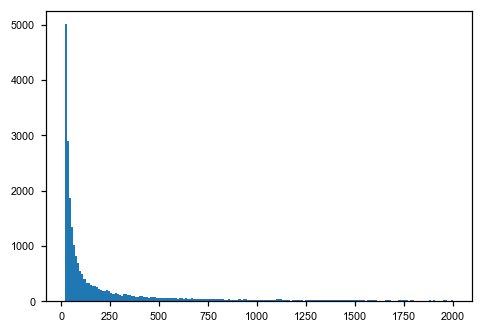

In [22]:
## don't need a function since the dict already exists
Xsamp = np.arange(1,n+1)/n
plt.hist([np.argmin(np.abs(dat[i,0]-Xsamp))+1 for i in range(len(dat))],bins=200);

In [250]:
# trueg1 = -0.01
trueg2 = -10.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:]
# newdf1 = newdf1.sample(frac=1)

newdat = newdf1.to_numpy()

In [160]:
gamma

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])

In [1958]:
# plt.hist(newdat[:,2],bins=100)
# plt.hist2d(np.log(newdat[:,0]),newdat[:,2][::-1],(25,25)); plt.colorbar()
# print(newdat[-5:,])
np.where(np.isinf(get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)))
# print(newdat[429,])
# get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)
# sXlred = np.around(newdat[:,0]*100).astype(int)
# np.sum((sXlred>0) & (sXlred<100))

(array([], dtype=int64),)

In [350]:
# np.around(newdat[429:431,0]*100).astype(int)
p_xa_s[-0.01][-1,20:198]

array([1.18810805e-11, 5.76230252e-12, 2.84279126e-12, 1.42496096e-12,
       7.24976110e-13, 3.74030108e-13, 1.95519652e-13, 1.03478075e-13,
       5.54093780e-14, 3.00002142e-14, 1.64143536e-14, 9.07097951e-15,
       5.06065029e-15, 2.84896530e-15, 1.61777502e-15, 9.26261634e-16,
       5.34539737e-16, 3.10823514e-16, 1.82054607e-16, 1.07378798e-16,
       6.37598866e-17, 3.81047397e-17, 2.29144753e-17, 1.38625580e-17,
       8.43505797e-18, 5.16128522e-18, 3.17520204e-18, 1.96359364e-18,
       1.22046611e-18, 7.62297654e-19, 4.78390557e-19, 3.01604245e-19,
       1.90998459e-19, 1.21479615e-19, 7.75897425e-20, 4.97601043e-20,
       3.20394728e-20, 2.07095074e-20, 1.34366119e-20, 8.74988968e-21,
       5.71830329e-21, 3.75011266e-21, 2.46772233e-21, 1.62924711e-21,
       1.07914946e-21, 7.17045703e-22, 4.77914936e-22, 3.19493500e-22,
       2.14215748e-22, 1.44042313e-22, 9.71293588e-23, 6.56759105e-23,
       4.45277929e-23, 3.02692009e-23, 2.06296351e-23, 1.40954787e-23,
      

In [102]:
## just doing a lookup of sorts for the right probability
def get_lp_alxl(g, sXlred, alred, n=2000, cutoff=20):
    # Xsamp = np.arange(1,n)/n
    # sXlred = np.around(Xlred*n).astype(int) # rng.binomial(n, Xlred, len(Xlred))
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1)))
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        # if too many gens, then pass in a very low number (like -400.)
        # res[i] = np.log(p_xa_s[g][-int(alred[i]),np.argmin(np.abs(Xlred[i]-Xsamp))+1]) if (int(alred[i]<p_xa_s[g].shape[0])) else -400. 
        
        res[idx] = np.log(up_xa_s[g][-int(alred[i]),int(sXlred[i])]) if (int(alred[i])<up_xa_s[g].shape[0]) else np.median(np.log(up_xa_s[g][0,:]))
        # if np.isinf(res[idx]):
        #     print(i, Xlred[i], alred[i])

    return res

In [88]:
limal[12]

103714

In [85]:
## finding how many alleles have ages beyond computed values in the lookup matrix/table (like 4)
for ig, g in enumerate(gamma):
    alred = df1['al'].iloc[ig*1000:(ig+1)*1000]
    print(g, np.sum(alred>up_xa_s[g].shape[0]))

-100.0 0
-68.12921 0
-46.41589 0
-31.62278 0
-21.54435 0
-14.67799 0
-10.0 0
-6.812921 0
-4.641589 1
-3.162278 0
-2.154435 2
-1.467799 0
-1.0 4
-0.6812921 1
-0.4641589 0
-0.3162278 0
-0.2154435 0
-0.1467799 0
-0.1 0
-0.06812921 0
-0.04641589 0
-0.03162278 0
-0.02154435 0
-0.01467799 0
-0.01 0


-0.01


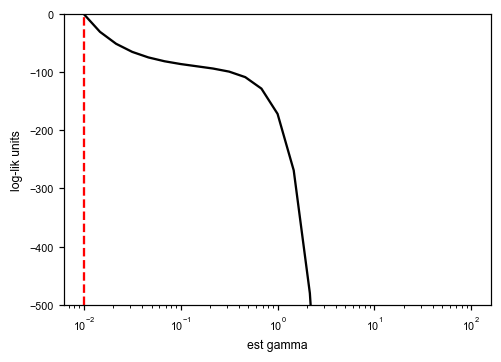

In [296]:
sin_onlyfreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5]))
plt.plot(-gamma,sin_onlyfreq-np.max(sin_onlyfreq),'k'); plt.ylim((-500,0)); plt.xlabel('est gamma'); plt.semilogx();
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='red', linestyle='--'); plt.ylabel('log-lik units')
print(gamma[np.argmax(sin_onlyfreq)])

-0.1


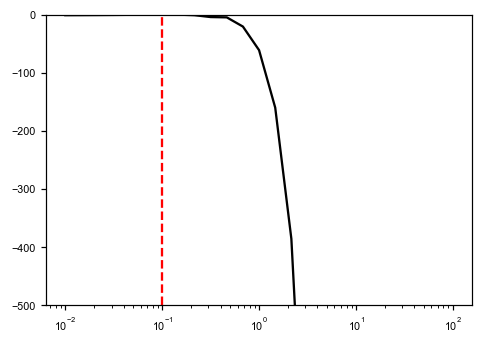

In [297]:
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2]))

plt.plot(-gamma,sin_onlyage-np.max(sin_onlyage),'k'); plt.ylim((-500,0)); plt.semilogx()
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='red', linestyle='--')
print(gamma[np.argmax(sin_onlyage)])

In [283]:
sin_onlyfreq

array([-72141.99535467, -47620.80329805, -31036.38314124, -19848.67866379,
       -12328.7683696 ,  -7300.67949657,  -3965.64626153,  -1782.81089105,
         -388.83464188,    458.66737123,    932.62383323,   1173.91389001,
         1289.51687783,   1344.32183443,   1371.1359702 ,   1385.17573209,
         1393.41786025,   1399.20556733,   1404.32742236,   1409.96108194,
         1417.14125769,   1427.04670042,   1441.24736742,   1461.99910797,
         1492.67169508])

In [284]:
# newdat[np.isnan(get_lp_alxl(-100., newdat[:,0], newdat[:,2], n=90)),]
sin_onlyage

array([-143098.88282424, -137660.53736071, -115799.76116287,
        -92418.9284118 ,  -72338.59889926,  -56753.01099962,
        -46447.04784183,  -40912.35391713,  -38191.51521468,
        -36930.72214162,  -36361.88972832,  -36110.83351044,
        -35995.57042901,  -35943.57409837,  -35920.7449662 ,
        -35910.99152368,  -35906.32544179,  -35904.38757692,
        -35903.64065068,  -35903.39703699,  -35903.35392269,
        -35903.38149159,  -35903.42667823,  -35903.46971107,
        -35903.50471116])

In [120]:
preds_sin_onlyfreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=25)) for g1 in gamma]
    preds_sin_onlyfreq[ig] = gamma[np.argmax(sin_onlyfreq)]

In [335]:
# preds_sin_agefreq = np.zeros(len(gamma))
# for ig, g in enumerate(gamma):
#     newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
#     newdat = newdf1.to_numpy()
#     sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]) + get_lp_xl(g1, newdat[:,5])) for g1 in gamma]
#     # sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]
#     preds_sin_agefreq[ig] = gamma[np.nanargmax(sin_agefreq)]

In [114]:
preds_sin_onlyage = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<60),:].to_numpy()
    sin_onlyage = [np.nansum(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.nanargmax(sin_onlyage)]

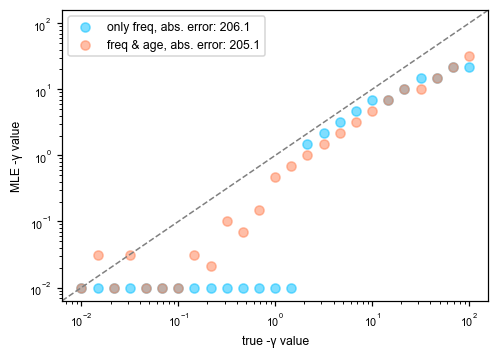

In [121]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq))))
plt.scatter(-gamma, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_onlyage))))
# plt.scatter(-gamma, -preds_sin_agefreq, color='darkgreen', alpha=0.5, label='age & freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_agefreq))))
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.legend(); plt.loglog()
plt.axline((100,100),(0,0),color='grey',ls='--', linewidth=1.)

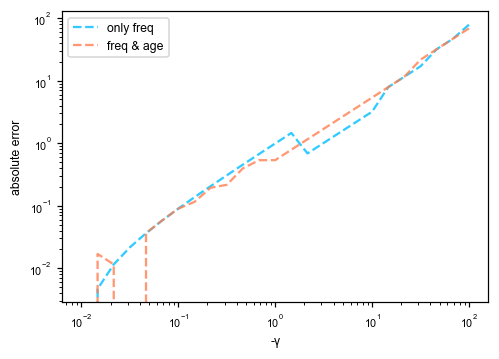

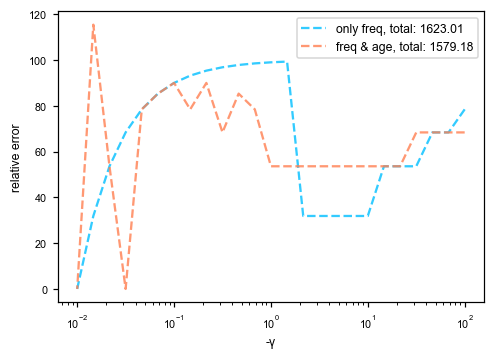

In [117]:
## plotting error rates across selection coefficients
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyfreq), color='deepskyblue', alpha=0.8, label='only freq'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq))), ls='--')
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyage), color='coral', label='freq & age', alpha=0.8, ls='--')
plt.legend(); plt.loglog(); plt.xlabel('-γ'); plt.ylabel('absolute error'); plt.show()

plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyfreq)*100/gamma, color='deepskyblue', alpha=0.8, label='only freq, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyfreq)*100/gamma)), ls='--')
plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyage)*100/gamma, color='coral', label='freq & age, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyage)*100/gamma)), alpha=0.8, ls='--')
plt.legend(); plt.semilogx(); plt.xlabel('-γ'); plt.ylabel('relative error'); plt.show()

In [287]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = -0.01
trueg2 = gamma[12]
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:])
# newdf1 = newdf1.sample(frac=1)

# only keeping alleles with ages > 1 (cos NN & PRF approx finds really high prob for these alleles to have small gamma...)
newdat = newdf1.to_numpy()

In [288]:
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))

# mask = np.full(dub_onlyfreq.shape,False)
# mask[np.triu_indices_from(dub_onlyfreq,k=1)] = True

array([-0.01, -0.01])

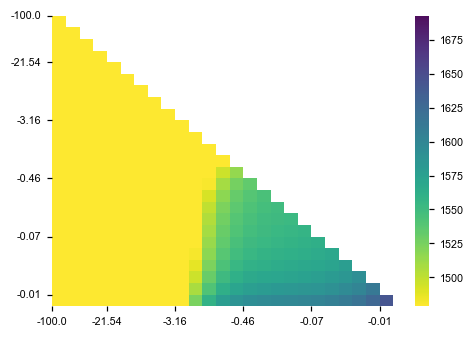

In [289]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',mask=mask,vmax=np.max(dub_onlyfreq[~mask]),vmin=np.max(dub_onlyfreq[~mask])+50)
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

In [290]:
## assuming two selection coefficients and only age info (split 50/50)
dub_onlyage = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_onlyage[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

array([-0.06812921, -0.4641589 ])

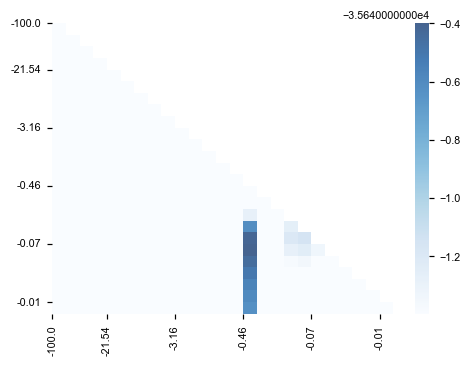

In [291]:
seaborn.heatmap(dub_onlyage,alpha=0.75,xticklabels=gamma,yticklabels=gamma,cmap='Blues',mask=mask,vmin=np.max(dub_onlyage[~mask])-1,vmax=np.max(dub_onlyage[~mask]))
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyfreq.shape))

In [274]:
# np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape)
# np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape)
# print(np.max(dub_onlyfreq[~mask]))
print(np.max(dub_onlyage[~mask]))
# dub_onlyfreq[24,]
dub_onlyage[21,]

-36244.31928789809


array([-37425.82354655, -37334.12021438, -37231.85174791, -37127.94847378,
       -37028.63585843, -36933.3939413 , -36838.94086939, -36738.95967864,
       -36625.1610307 , -36499.45303871, -36391.64887289, -36321.50686871,
       -36282.45379539, -36262.38977677, -36252.82154178, -36248.26597081,
       -36245.94413791, -36244.93799862, -36244.52407229, -36244.36924316,
       -36244.32309751, -36244.3192879 ,      0.        ,      0.        ,
            0.        ])

In [299]:
# print(2.*(dub_onlyfreq[gamma==gamma[24],gamma==gamma[24]] - sin_onlyfreq[gamma==gamma[24]]))
# print(2.*(dub_onlyage[gamma==gamma[19],gamma==gamma[14]] - sin_onlyage[gamma==gamma[18]]))

0.22067136191984324

### What if there was only one $\gamma$ in the data? 

In [32]:
samepredsonlyfreq = np.zeros((len(gamma),4))
samepredsagefreq = np.zeros((len(gamma),4))
for itg, trueg in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg)),:]

    newdat = newdf1.to_numpy()
    
    sin_onlyfreq = np.zeros(len(gamma))
    sin_agefreq = np.zeros(len(gamma))
    
    dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
    dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search

    for ig1, g1 in enumerate(gamma):
        sin_onlyfreq[ig1] = np.sum(get_lp_xl(g1, newdat[:,5]))
        # sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0]))
        sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]))

        for ig2, g2 in enumerate(gamma[0:(ig1+1)]):        
            dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))
    
            # dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g2, newdat[:,0]))))
            
            dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

    estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

    estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
    estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

    lambfreq = 2.*(np.max(dub_onlyfreq[~mask]) - np.max(sin_onlyfreq))

    samepredsonlyfreq[itg,2] = estgonlyfreq

    samepredsonlyfreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

    if(chi2.sf(lambfreq, 1)<0.05):
        samepredsonlyfreq[itg,3] = True
    else:
        samepredsonlyfreq[itg,3] = False

    estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

    estg1agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[0]
    estg2agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[1]

    lambagefreq = 2.*(np.nanmax(dub_agefreq[~mask]) - np.nanmax(sin_agefreq))

    samepredsagefreq[itg,2] = estgagefreq

    samepredsagefreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))

    if(chi2.sf(lambagefreq, 1)<0.05):
        samepredsagefreq[itg,3] = True
    else:
        samepredsagefreq[itg,3] = False

In [33]:
# np.max(dub_onlyfreq) - np.max(sin_onlyfreq)
samepredsagefreq

array([[-2.154435e+01, -3.162278e+01, -3.162278e+01,  1.000000e+00],
       [-2.154435e+01, -2.154435e+01, -2.154435e+01,  0.000000e+00],
       [-1.467799e+01, -1.467799e+01, -1.467799e+01,  0.000000e+00],
       [-1.000000e+01, -1.467799e+01, -1.000000e+01,  1.000000e+00],
       [-6.812921e+00, -1.000000e+01, -1.000000e+01,  1.000000e+00],
       [-6.812921e+00, -6.812921e+00, -6.812921e+00,  0.000000e+00],
       [-4.641589e+00, -4.641589e+00, -4.641589e+00,  0.000000e+00],
       [-3.162278e+00, -3.162278e+00, -3.162278e+00,  0.000000e+00],
       [-1.467799e+00, -3.162278e+00, -1.467799e+00,  1.000000e+00],
       [-1.467799e+00, -1.467799e+00, -1.467799e+00,  0.000000e+00],
       [-1.000000e+00, -1.000000e+00, -1.000000e+00,  0.000000e+00],
       [-6.812921e-01, -6.812921e-01, -6.812921e-01,  0.000000e+00],
       [-2.154435e-01, -2.154435e-01, -2.154435e-01,  0.000000e+00],
       [-1.467799e-01, -1.467799e-01, -1.467799e-01,  0.000000e+00],
       [-6.812921e-02, -6.812921e-

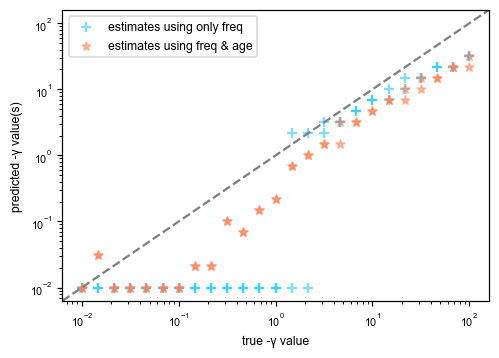

In [34]:
## plotting the above results
plt.scatter(-gamma, -samepredsonlyfreq[:,0], color='deepskyblue', marker='+', alpha=0.5)
plt.scatter(-gamma, -samepredsonlyfreq[:,1], color='deepskyblue', marker='+', label='estimates using only freq', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,0], color='coral', marker='*', label='estimates using freq & age', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,1], color='coral', marker='*', alpha=0.5)
plt.xlabel('true -γ value'); plt.ylabel('predicted -γ value(s)'); plt.loglog()
plt.axline((0.01,0.01),(100,100),color='grey',ls='--'); plt.legend()

### Template code to compute difference in $\gamma$ given set of data

Here, I will run the mechanism to compute the probability of a significant difference in selection coefficients is detected given a set of large data i.e., 2000 data points and I will resample 25 times to obtain smaller datasets of 500. 

In [196]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.
    sin_onlyfreq = np.empty(len(gamma))
    dub_onlyfreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,5]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyfreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g, newnewdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newnewdat[:,5]))))


        estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

        # estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
        # estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]
        estg1onlyfreq, estg2onlyfreq = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

        lambfreq = 2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])

        if(chi2.sf(lambfreq, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyfreq, np.array([estg1onlyfreq, estg2onlyfreq])]

In [36]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_agefreq = np.empty(len(gamma))
    
    dub_agefreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_agefreq[ig] = np.sum(get_lp_alxl(g, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_agefreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g, newnewdat[:,5])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g2, newnewdat[:,5]))))

        estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

        estg1agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[0]]
        estg2agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[1]]

        lambagefreq = 2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])

        if(chi2.sf(lambagefreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [197]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_age(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_onlyage = np.empty(len(gamma))
    
    dub_onlyage = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyage[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2]))))

        estgonlyage = gamma[np.argmax(sin_onlyage)]        

        # estg1onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[0]]
        # estg2onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[1]]
        estg1onlyage, estg2onlyage = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape))

        lambonlyage = 2.*(dub_onlyage[gamma==estg1onlyage,gamma==estg2onlyage] - sin_onlyage[gamma==estgonlyage])

        if(chi2.sf(lambonlyage, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyage, np.array([estg1onlyage, estg2onlyage])]

In [198]:
diffgamma = [(-0.01, x) for x in gamma[:-1][::2]] # list(it.combinations(gamma[0::3], 2))
diffprobs = np.zeros((len(diffgamma),2))
sinpreds = np.zeros((len(diffgamma),2))
dubpreds = np.zeros((len(diffgamma),4))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0], sinpreds[ig,0], dubpreds[ig,:2] = resample_calculateprob_freq(newdat, gamma, num_sims=10, num_samps=600)
    diffprobs[ig,1], sinpreds[ig,1], dubpreds[ig,-2:] = resample_calculateprob_age(newdat, gamma, num_sims=10, num_samps=600)

In [205]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==gamma[-2])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==gamma[-1])),:])
# newdat = newdf1.to_numpy()
# print(resample_calculateprob_freq(newdat, gamma, num_sims=10, num_samps=1000))
# print(resample_calculateprob_age(newdat, gamma, num_sims=10, num_samps=1000))
diffgamma

[(-0.01, -100.0),
 (-0.01, -46.41589),
 (-0.01, -21.54435),
 (-0.01, -10.0),
 (-0.01, -4.641589),
 (-0.01, -2.154435),
 (-0.01, -1.0),
 (-0.01, -0.4641589),
 (-0.01, -0.2154435),
 (-0.01, -0.1),
 (-0.01, -0.04641589),
 (-0.01, -0.02154435)]

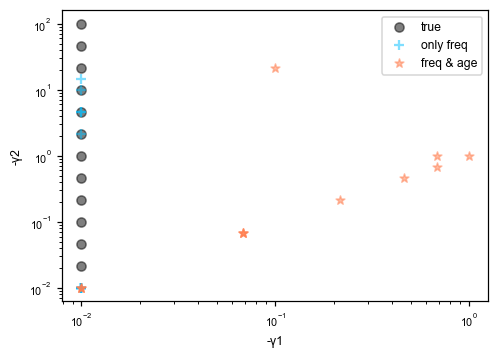

In [199]:
plt.scatter([np.abs(g[0]) for g in diffgamma], [np.abs(g[1]) for g in diffgamma], color='k', label='true', marker='o', alpha=0.5)
plt.scatter(-dubpreds[:,0], -dubpreds[:,1], color='deepskyblue', marker='+', label='only freq', alpha=0.5)
plt.scatter(-dubpreds[:,2], -dubpreds[:,3], color='coral', marker='*', label='freq & age', alpha=0.5)
plt.xlabel('-γ1'); plt.ylabel('-γ2'); plt.loglog(); plt.legend()

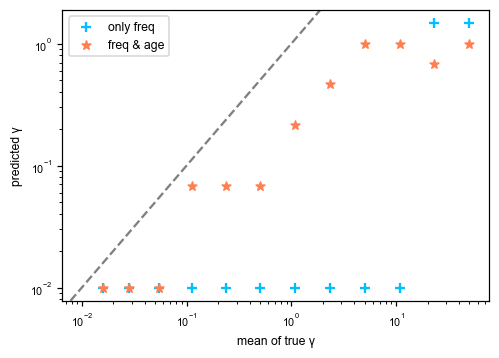

In [200]:
plt.scatter([-np.mean(g) for g in diffgamma], -sinpreds[:,0], color='deepskyblue', marker='+', label='only freq')
plt.scatter([-np.mean(g) for g in diffgamma], -sinpreds[:,1], color='coral', marker='*', label='freq & age',)
plt.xlabel('mean of true γ'); plt.ylabel('predicted γ'); plt.loglog(); plt.legend() 
plt.axline((0.01,0.01),(1,1),color='grey',ls='--')

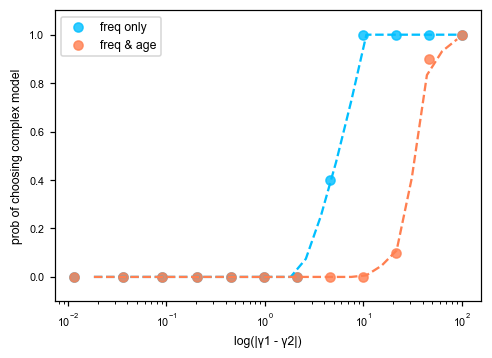

In [201]:
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], color='deepskyblue', alpha=0.7, label='freq only') #s=truenumlocifreq[:-1]/(truenumlocifreq[:-1]+truenumlocifreq[-1])*70.)
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], color='coral', alpha=0.7, label='freq & age')
ginterp = np.logspace(-4,4.5,base=np.exp(1),num=25)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='deepskyblue', alpha=0.7)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='coral', alpha=0.7)
plt.ylim((-0.1,1.1)); plt.xscale('log'); plt.xlabel('log(|γ1 - γ2|)'); plt.ylabel('prob of choosing complex model'); plt.legend()

In [38]:
truenumloci = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    sXlred = newdf1['sXl']
    truenumloci[ig] = np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))

truenumlocifreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    truenumlocifreq[ig] = newdf1.to_numpy().shape[0]

truenumloci

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000.,  999.,  999.,  998.,  999.,  999.,  997.,  998.,
        999.,  999., 1000., 1000.,  998.,  998.,  996.])

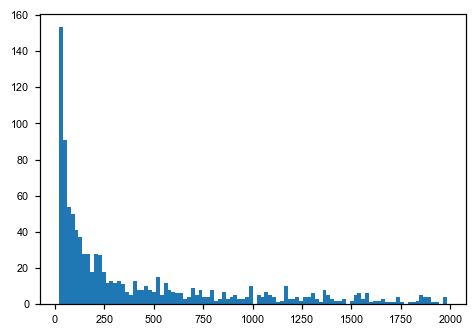

In [270]:
plt.hist(df1['sXl'][19000:20000],100);

In [110]:
# diffgamma
## number of alleles decrease since most of them have age=0
# [diffgamma, diffprobs]

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])